In [ ]:
#importing the necessary libraries
import numpy as np 
import pandas as pd 
import random

# folder
import os
import glob

# image
from PIL import Image

# visualization
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Connecting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<b>There are two categories in three sets:</b>

In [ ]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

<b>Computing the average size of the images among all categories and all datasets:</b>

In [ ]:
widths = []
heights = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('drive/My Drive/xray dataset' + set_ + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

Average image width: 1327.88
Average image height: 970.69
CPU times: user 1.95 s, sys: 1.43 s, total: 3.38 s
Wall time: 46.3 s


In [ ]:
im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " + str(im_width))
print("image height: " + str(im_height))

image width: 132
image height: 97


In [ ]:
data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob('drive/My Drive/xray dataset' + set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])

data_array = np.stack(data, axis=0)

In [ ]:
print(data_array.shape)

(5856, 97, 132)


In [ ]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

,count,%
PNEUMONIA,4273,73
NORMAL,1583,27


<b>Viewing random images and associated label of our dataset</b>

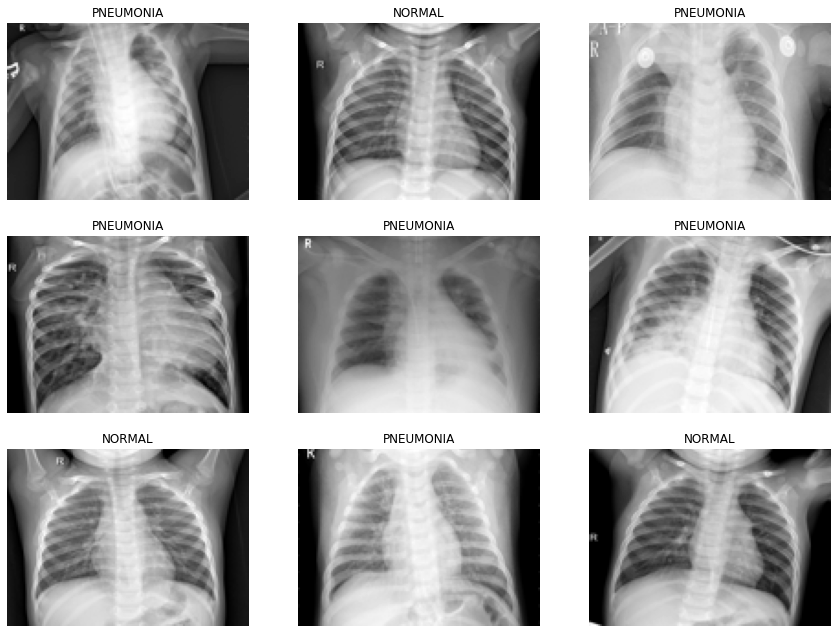

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4684, 97, 132)
(1172, 97, 132)
(4684,)
(1172,)


# Normalizing the data

In [ ]:
print(X_train.max())
print(X_train.min())

255
0


In [ ]:
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [ ]:
print(X_train_norm.max())
print(X_train_norm.min())

1.0
0.0


**checking the normalised pictures randomly** </b>

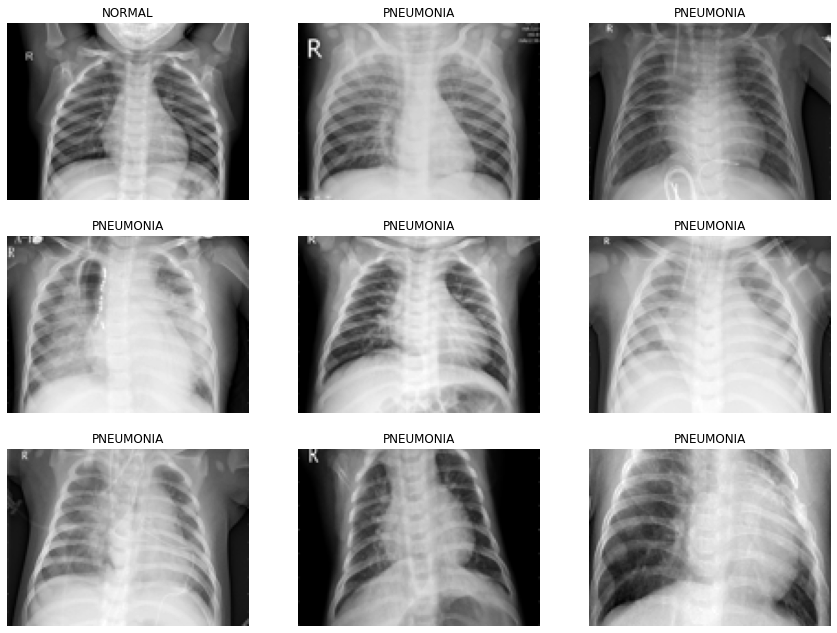

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image]);

## Target encoding

In [ ]:
encoder = LabelEncoder().fit(y_train)

In [ ]:
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

### Expanding dimension of the image


In [ ]:
X_train_norm.shape

(4684, 97, 132)

In [ ]:
X_train_norm = X_train_norm.reshape(-1, 97, 132, 1)
X_test_norm = X_test_norm.reshape(-1, 97, 132, 1)
X_train_norm.shape

(4684, 97, 132, 1)

In [ ]:
X_test_norm.shape

(1172, 97, 132, 1)

# Model Building

In [ ]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
model = initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 97, 132, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 66, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 33, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 11, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11264)            

In [ ]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [ ]:
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_norm, y_train_cat,
                    batch_size=8,
                    epochs=1000,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/1000
410/410 [==============================] - 3s 7ms/step - loss: 0.3718 - accuracy: 0.8392 - val_loss: 0.2762 - val_accuracy: 0.8876
Epoch 2/1000
410/410 [==============================] - 2s 6ms/step - loss: 0.1850 - accuracy: 0.9356 - val_loss: 0.1578 - val_accuracy: 0.9381
Epoch 3/1000
410/410 [==============================] - 2s 6ms/step - loss: 0.1459 - accuracy: 0.9478 - val_loss: 0.1488 - val_accuracy: 0.9509
Epoch 4/1000
410/410 [==============================] - 2s 6ms/step - loss: 0.1456 - accuracy: 0.9469 - val_loss: 0.1413 - val_accuracy: 0.9438
Epoch 5/1000
410/410 [==============================] - 3s 7ms/step - loss: 0.1078 - accuracy: 0.9576 - val_loss: 0.1239 - val_accuracy: 0.9552
Epoch 6/1000
410/410 [==============================] - 2s 6ms/step - loss: 0.0967 - accuracy: 0.9674 - val_loss: 0.1403 - val_accuracy: 0.9495
Epoch 7/1000
410/410 [==============================] - 2s 6ms/step - loss: 0.0917 - accuracy: 0.9664 - val_loss: 0.1211 - val_accuracy:

# 6. Results & Evaluation

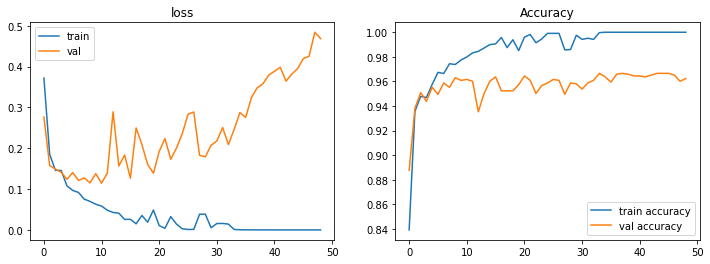

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

In [ ]:
model.evaluate(X_test_norm, y_test_cat, verbose=0)

[0.22647355496883392, 0.9658703207969666]

In [ ]:
predictions = model.predict(X_test_norm)

 **Visualizing the True and Predicted Label**

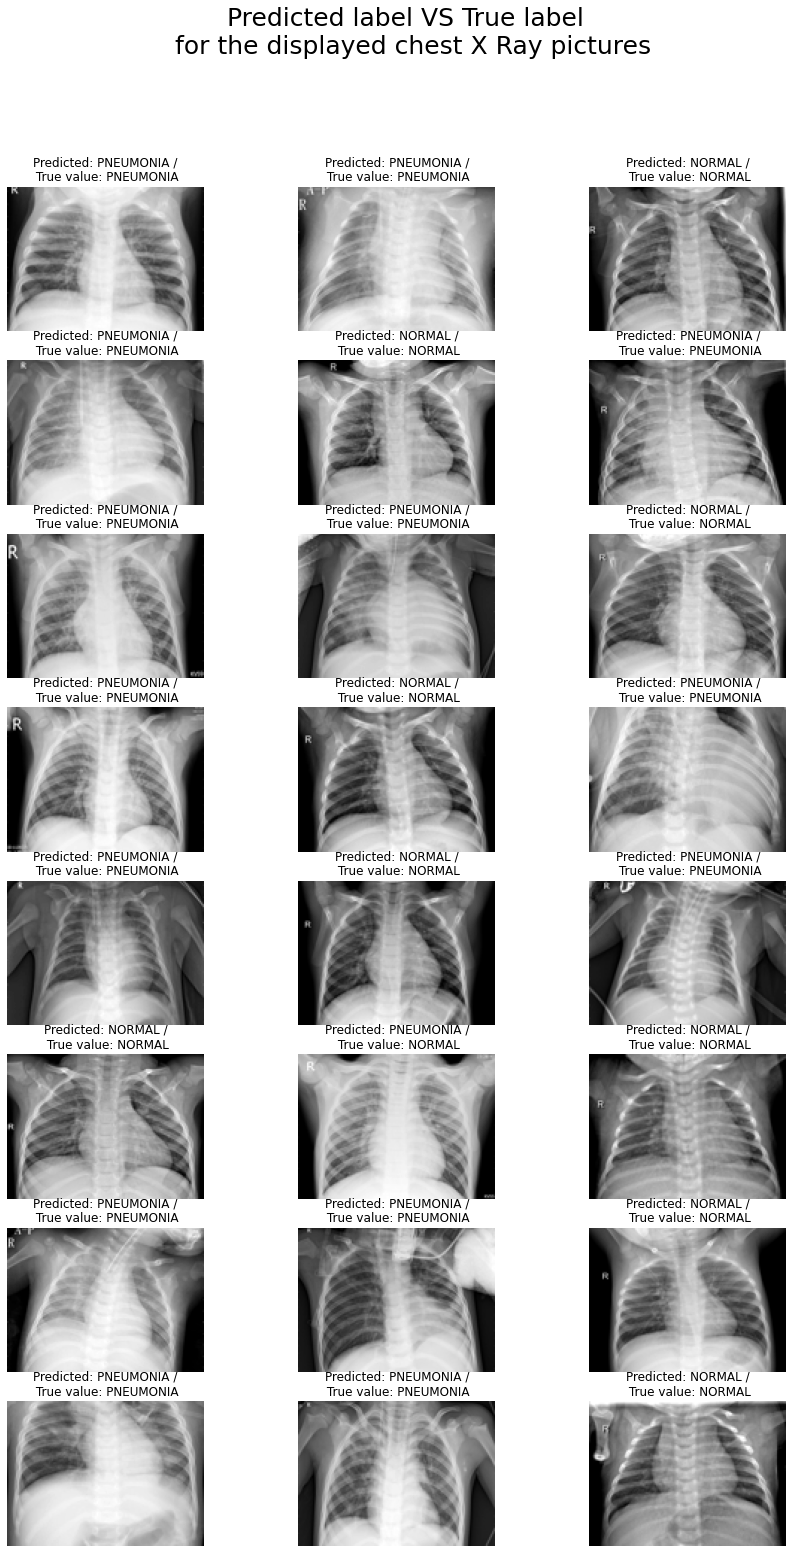

In [ ]:
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(8, 4)
#
for row in range(0, 8):
    for col in range(0, 3):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title("Predicted: " + categories[int(np.round(predictions)[num_image][0])] + " /\n True value: " + categories[y_test_cat[num_image]])
        ax.imshow(X_test_norm[num_image]);
fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);
#plt.tight_layout;